# Analyse der bereits nach Wikidata verlinkten Gartenlaube Artikel

Dieses Skript soll verschiedene Analysen der bereits in Wikidata verlinkten Gartenlaube Artikel vor allem hinsichtlich der Verbesserung der Datenqualität und ihrere Homogenisierung ermöglichen.

Die bereits vorhandenen WD-Items wurden über ein Parsing aller Gartenlaube-Artikel auf de.wikisource via der Media-Wiki-API durch Extraktion der gegebenfalls hinterlegaten Wikibase-ID definiert.
Die hier verwendete [Liste](https://paws-public.wmflabs.org/paws-public/User:Mfchris84/existQID.txt) an QIDs stammt aktuell von 09. März 2019 20.00 Uhr UTC.

## 1. Zählung aller vorhandenen Properties

Es werden die Properties aller Wikidata-Items ausgelesen und deren Vorkommen gezählt. In einer [Tabelle](#cell2) werden sortiert nach ihren Vorkommen die häufigsten Properties dargestellt.

## 2. Verteilung der verwendeten P31 Objekt-Items

Auch um die Datenqualität der vorhandenen Items analysieren zu können, ist eine Auswertung der verwendeten Objekte im Statement P31 (instance of) interessant. [Graphik](#cell3) zeigt die Häufigkeit der verwendeten Items in Gartenlaube-Artikel als Statement mit Property P31.


## 3. Verteilung der Anzahl an Items zu Gartenlaube-Artikel nach Anzahl an Statements.
In allen ca. 7.700 angelegten Items befinden sich in Summe 16.142 Statements, das sind durchschnittlich nur 2 Statements je Item.
Das [Diagramm](#NoStat) zeigt die Verteilung genauer an. Items mit sehr hoher Anzahl an Statements weisen wieder auf eine wahrscheinlich falsche Verlinkung (bspw. an ein geographisches oder biographisches Item) hin.

In [1]:
import requests
import re
import json
import urllib
import collections, numpy

S = requests.Session()
URL = "https://de.wikisource.org/w/api.php"
def parseWikiAPI(URL,PARAMS):
    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()
    return DATA


def countStatements(wdataClaims,qid):
    stmSum = 0
    for claim in wdataClaims:
        stmSum = stmSum + len(wdataClaims[claim])
    return stmSum


lines = [line.rstrip('\n') for line in open('output/existQID1636314257.txt')]
wbapi = "https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&ids="

newlist = [[],[],[],[0],[]]
newlistC = list()
artikelCounter = 0
p31d = dict()
default_data = {}
for qid in lines:
    url = wbapi+qid
    #print(url)

    params=""
    wbjson = (parseWikiAPI(url,params))
    labels = wbjson["entities"][qid]["labels"].keys()
    for key in labels:
       # print(key)
    #print (labels)
        newlist[0].append(key)

    #print(newlist)

    labelList = numpy.array(newlist[0])

    claims = wbjson["entities"][qid]["claims"].keys()
    
    for key in claims:
        newlist[1].append(key)

    try:
        for P31 in wbjson["entities"][qid]["claims"]["P31"]:
            #p31d[P31["mainsnak"]["datavalue"]["value"]["id"]] = qid
            #p31d[str(P31["mainsnak"]["datavalue"]["value"]["id"])]
            if P31["mainsnak"]["datavalue"]["value"]["id"] not in p31d:
                p31d.update({P31["mainsnak"]["datavalue"]["value"]["id"]:[qid]})
            else:
                p31d[P31["mainsnak"]["datavalue"]["value"]["id"]].append(qid)

            #p31d.update({P31["mainsnak"]["datavalue"]["value"]["id"]: qid})
    except KeyError:
        if "noP31" not in p31d:
            p31d.update({"noP31":[qid]})
        else:
            p31d["noP31"].append(qid)

    #print(p31d)
    
    #claimList = numpy.array(newlist[1])
    #print(a)
    #print(collections.Counter(labelList))
    #print(collections.Counter(claimList))
    #p31qList = numpy.array(newlist[2])
    #print (p31qList)
    #print(collections.Counter(p31qList))
    newlist[3][0] = newlist[3][0]+1
    #print(newlist[3][0])

    newlist[4].append({"'"+qid+"'":countStatements(wbjson["entities"][qid]["claims"],qid)})


<a id="cell2"></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

claimList = numpy.array(newlist[1])
listClaimCount  = collections.Counter(claimList).most_common()

s = pd.Series(listClaimCount)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(s)

df = pd.DataFrame(listClaimCount,columns=["Prop","Count"])

df

,Prop,Count
0,P31,16108
1,P577,16108
2,P1476,16104
3,P1433,16102
4,P407,16093
5,P433,15528
6,P304,15347
7,P6216,13044
8,P921,11679
9,P18,4663


<a id='cell3'></a>

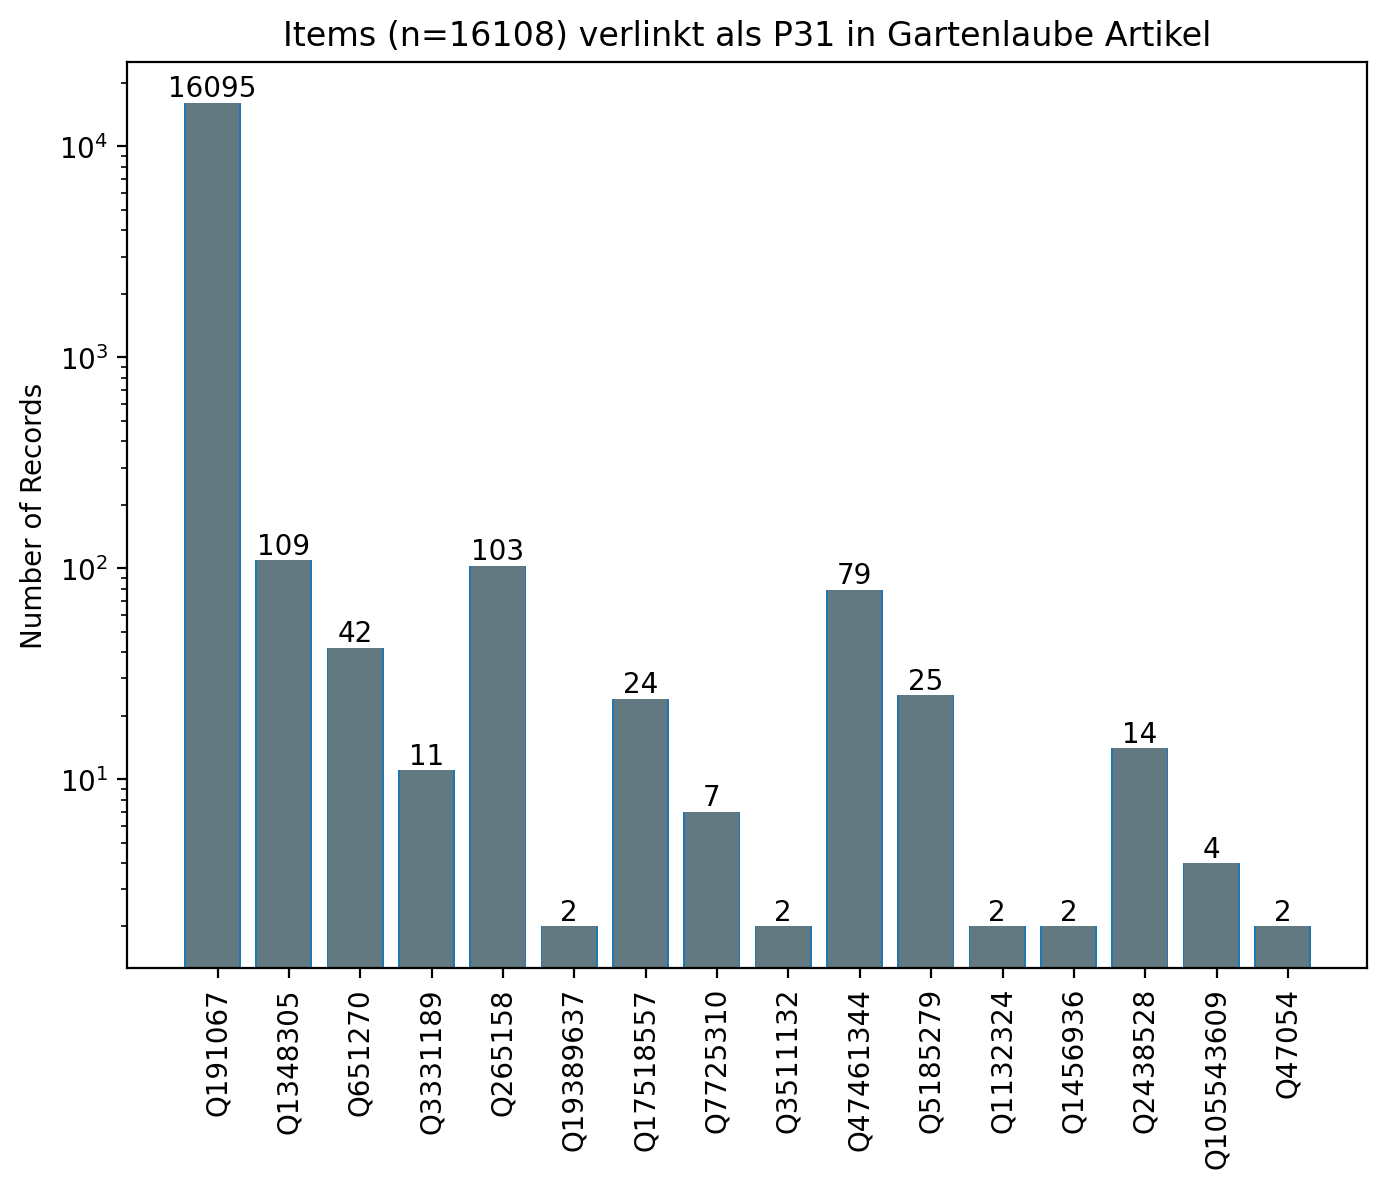

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#Analyzing P31
#print(p31d)

labels = list()
values = list()
solitP31 = list()

w = 7195
h = 3841


for p31q in p31d:
    if len(p31d[p31q]) > 1:
        labels.append(p31q)
        values.append(len(p31d[p31q]))
    else:
        solitP31.append(p31q)
    
#print(labels)
#print(values)

fig = plt.figure(num=None, figsize=(8, 6), dpi=200,  facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

indexes = np.arange(len(labels))
width = 0.75
rects1 = ax.bar(indexes, values )
for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%d' % int(height),
                ha='center', va='bottom')


     
        
bars = plt.bar(indexes, values, width,alpha=0.3)

plt.xticks(indexes + width*0.1 , labels,rotation='vertical',)
plt.yticks([0,50,100,500,1000,8000])
plt.yscale('log')
plt.ylabel('Number of Records')
plt.title('Items (n=16108) verlinkt als P31 in Gartenlaube Artikel')


plt.show()


In [6]:
solitList = []
solitListwikitable = []
for item in solitP31:
    solitListwikitable.append(("[[d:"+item+"]]","[[d:"+p31d[item][0]+"]]"))
    solitList.append((item,p31d[item][0]))

df = pd.DataFrame(solitList,columns=["P31-Objectitem","Wikidata-Item für Gartenlaube-Artikel"])

df

,P31-Objectitem,Wikidata-Item für Gartenlaube-Artikel
0,Q19362971,Q19153764
1,Q1164267,Q19157551
2,Q182659,Q19176826
3,Q858157,Q19238213
4,Q602446,Q19214504
5,Q7366,Q19214504
6,Q1347298,Q19166127
7,Q133492,Q19199311
8,Q637866,Q62613019
9,Q820593,Q64212346


<a id="NoStat"></a>

Summe aller Statements: 176774
Durchschnittliche Anzahl an Statements je Item: 10.973617232602892


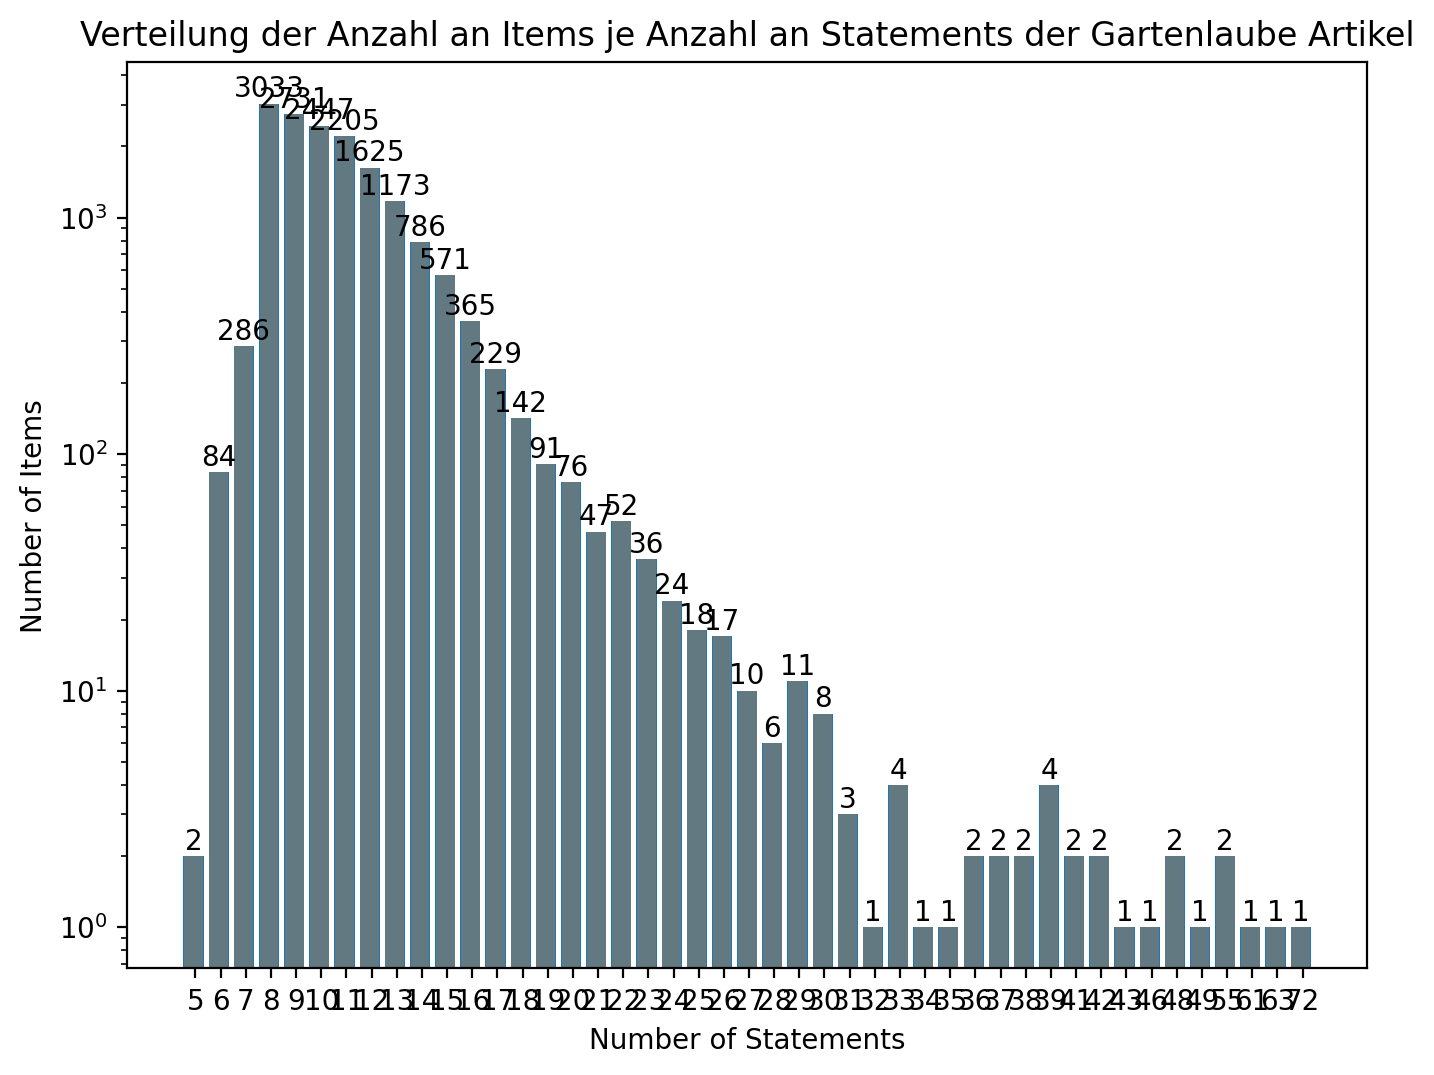

In [7]:
sum = 0
#print(newlist[4])
statLen = []
for item in newlist[4]:
    #print(item)
    for key in item:
        #print(key)
        sum = sum + item[key]
        statLen.append(item[key])
    
print("Summe aller Statements: "+str(sum))
print("Durchschnittliche Anzahl an Statements je Item: "+str(sum/len(newlist[4])))

statCount = numpy.array(statLen)
listClaimCount  = collections.Counter(statCount)
listClaimCount=sorted(listClaimCount.items())
#print(listClaimCount)
values = []
labels = []
for index in listClaimCount:
    labels.append(index[0])
    values.append(index[1])

fig = plt.figure(num=None, figsize=(8, 6), dpi=200,  facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

indexes = np.arange(len(labels))
width = 0.75

rects1 = ax.bar(indexes, values )
for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%d' % int(height),
                ha='center', va='bottom')

bars = plt.bar(indexes, values, width,alpha=0.3)

plt.xticks(indexes + width*0.1 , labels,)
plt.yticks([0,50,100,500,1000,8000])
plt.yscale('log')
plt.ylabel('Number of Items')
plt.xlabel('Number of Statements')
plt.title('Verteilung der Anzahl an Items je Anzahl an Statements der Gartenlaube Artikel')


plt.show()